# Compare SVR, NN, GPR Optimization Results

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import csv
plt.style.use(plt.style.available[11])

In [2]:
noise = 30
train_pts = 2000
E_cutoffs = [1, 0.5, 0.25]
etas = [1, 0.4, 0.175]
models = ['gpr', 'svr', 'nn'] #['train', 'svr', 'gpr', 'nn']
fuchs_thickness_left = [None for _ in range(len(E_cutoffs))]
fuchs_thickness_right = [None for _ in range(len(E_cutoffs))]
fuchs_thickness_center = [None for _ in range(len(E_cutoffs))]
fuchs_offset_left = [None for _ in range(len(E_cutoffs))]
fuchs_offset_right = [None for _ in range(len(E_cutoffs))]
fuchs_offset_center = [None for _ in range(len(E_cutoffs))]
model_results = [None for _ in range(len(models))]
for i in range(len(E_cutoffs)):
    fuchs_thickness_left[i] = np.load('npy_files/fuchs_thickness_left_E={}.npy'.format(E_cutoffs[i]))
    fuchs_thickness_right[i] = np.load('npy_files/fuchs_thickness_right_E={}.npy'.format(E_cutoffs[i]))
    fuchs_thickness_center[i] = np.load('npy_files/fuchs_thickness_center_E={}.npy'.format(E_cutoffs[i]))
    fuchs_offset_left[i] = np.load('npy_files/fuchs_offset_left_E={}.npy'.format(E_cutoffs[i]))
    fuchs_offset_right[i] = np.load('npy_files/fuchs_offset_right_E={}.npy'.format(E_cutoffs[i]))
    fuchs_offset_center[i] = np.load('npy_files/fuchs_offset_center_E={}.npy'.format(E_cutoffs[i]))

for i in range(len(models)):
    model_results[i] = pd.read_csv('predictions_dfs/{}_noise={}_train_pts={}.csv'.format(models[i], noise, train_pts))
model_results[0].head()

,Intensity,Thickness,Offset,E Max,E Tot,E Avg
0,1.000000e+19,5.584942,2.177699,0.359296,1.079548e+08,0.089884
1,1.000000e+19,9.088420,5.872497,0.135487,3.060141e+07,0.036878
2,1.000000e+19,5.272767,9.876133,0.167826,3.577963e+07,0.042082
3,1.000000e+19,1.458265,9.508670,0.504801,1.146508e+08,0.101814
4,1.000000e+19,5.512029,3.429715,0.342991,1.001401e+08,0.085677


In [3]:
def calc_laser_energy(I0, w0=1.5e-6, tFWHM=40.0e-15):
    return (np.pi/2)*I0*w0**2 * tFWHM # For a Sine-Squared Pulse
print('min laser energy: ', calc_laser_energy(1e22)*1e3, 'mJ')
print('max laser energy: ', calc_laser_energy(1e23)*1e3, 'mJ')

def objective_function(x, E_cutoff=0.1, η=0.5, penalty=True, only_term2 = False):
    Intensity = x[0] # Laser Intensity
    Thickness = x[1] # Target Thickness
    Offset = x[2] # Focal Offset
    E_max = x[3] # Max Energy
    E_tot = x[4] # Total Energy
    E_avg = x[5] # Average Energy
    Laser_Energy = calc_laser_energy(Intensity*1e4)
    Conversion_Efficiency = (E_tot*1.609e-13)/Laser_Energy
    N_p = E_tot/E_avg
    term1 = np.abs(E_max - E_cutoff)/E_cutoff if not only_term2 else 0 # Wanting to Match E_max to E_cutoff
    term2 = η*(4.5e-3)/Conversion_Efficiency # Wanting to obtain high conversion efficiency
    penalty_term = 1e6 if (np.abs(E_max-E_cutoff)/E_cutoff > 0.15 and penalty==True) else 0 # Penalizing if E_max is too far from E_cutoff
    obj = term1 + term2 + penalty_term
    return obj

def model(x):
    Intensity = x.iloc[:, 0] # Laser Intensity
    Thickness = x.iloc[:, 1] # Target Thickness
    Offset = x.iloc[:, 2] # Focal Offset
    E_max = x.iloc[:, 3] # Max Energy
    E_tot = x.iloc[:, 4] # Total Energy
    E_avg = x.iloc[:, 5] # Average Energy
    Laser_Energy = calc_laser_energy(Intensity*1e4)
    Conversion_Efficiency = (E_tot*1.609e-13)/Laser_Energy
    return Conversion_Efficiency, E_tot, Laser_Energy

efficiencies, total, laser = model(model_results[0])
print('min: ', efficiencies.min(), 'max: ', efficiencies.max(), 'mean: ', efficiencies.mean())
print('min: ', total.min(), 'max: ', total.max(), 'mean: ', total.mean())
print('min: ', laser.min(), 'max: ', laser.max(), 'mean: ', laser.mean())


min laser energy:  1.4137166941154071 mJ
max laser energy:  14.137166941154067 mJ
min:  0.00014448409149760578 max:  0.005647324896590466 mean:  0.0013776263319150144
min:  12694814.927548986 max:  496191266.8367623 mean:  121042470.0858439
min:  0.014137166941154067 max:  0.014137166941154067 mean:  0.014137166941154076


1.139976158816997
0.8668682661894532
0.8173710321041006
1.1422238074548212
0.8535037700041955
0.7983961891202893
1.2056911640325874
0.914048492148462
0.8419025188358596


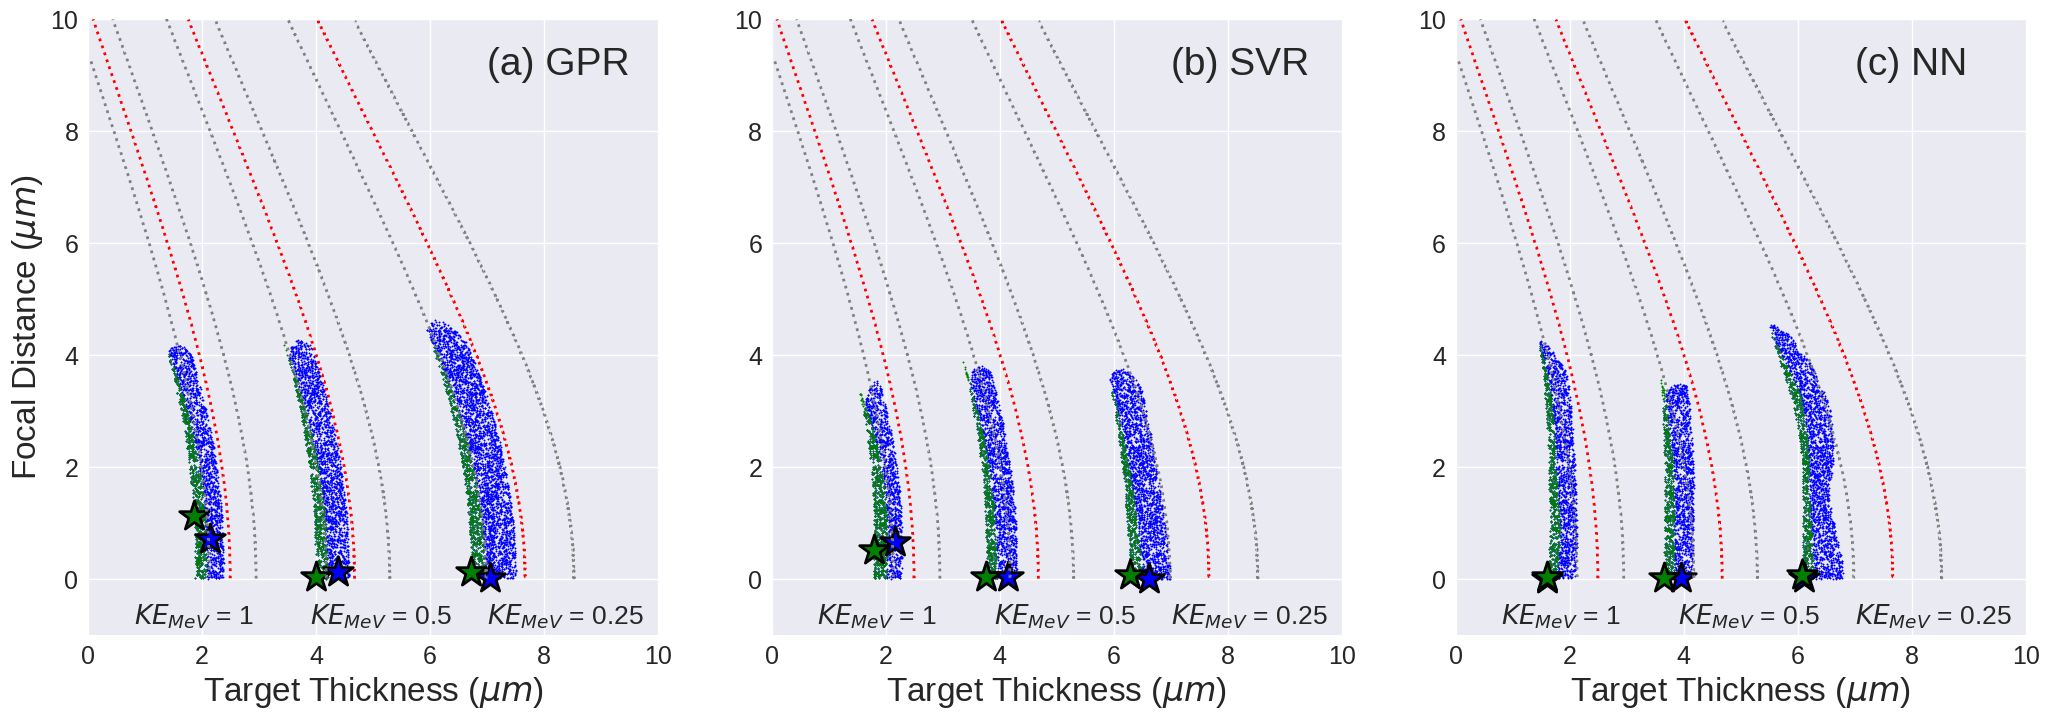

In [4]:
thick_xs = [0.8, 3.9, 7] # x-axis labels for thickness
bounds = [(1e19, 1e19), (0.0, 10.0), (-1, 10.0)]
colors = ['blue', 'green', 'red']
threshold = 5 # region of best points that are within (threshold) pct of optimal value
tol = 1e-2
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,8))
size1 = 1
size2 = 500
foo = ['(a)', '(b)', '(c)']
ax[0].set_ylabel('Focal Distance ($\mu m$)', fontsize=24)

for i in range(len(models)):
    ax[i].set_xlabel('Target Thickness ($\mu m$)', fontsize=24)
    ax[i].set_xlim(bounds[1])
    ax[i].set_ylim(bounds[2])
    ax[i].tick_params(axis='both',  labelsize=18)
    ax[i].set_axisbelow(True)
    ax[i].text(7, 9, foo[i] + ' ' + models[i].upper(), fontsize=28)
    for j in range(len(E_cutoffs)):
        E_cutoff = E_cutoffs[j]
        η = etas[j]

        ax[i].plot(fuchs_thickness_left[j], fuchs_offset_left[j], color='gray', linewidth=2, linestyle='dotted')
        ax[i].plot(fuchs_thickness_right[j], fuchs_offset_right[j], color='gray', linewidth=2, linestyle='dotted')
        ax[i].plot(fuchs_thickness_center[j], fuchs_offset_center[j], color='red', linewidth=2, linestyle='dotted')
        
        model_results_mix = model_results[i].copy()
        model_results_mix['objective_function'] = model_results_mix.apply(objective_function, args=(E_cutoff, η, True, False), axis=1)
        model_results_mix.sort_values(by=['objective_function'], ascending=True, inplace=True)

        model_results_eff = model_results[i].copy()
        model_results_eff['objective_function'] = model_results_eff.apply(objective_function, args=(E_cutoff, η, True, True), axis=1)
        model_results_eff.sort_values(by=['objective_function'], ascending=True, inplace=True)
        print(model_results_eff['objective_function'].iloc[0])

        optimal_value_model_1 = model_results_mix['objective_function'].iloc[0]
        locations_model_1 = model_results_mix.loc[model_results_mix['objective_function'] <= (1 + threshold/100)*optimal_value_model_1 + tol]
        ax[i].scatter(locations_model_1['Thickness'], locations_model_1['Offset'], label='Mix', color='blue', s=size1) 

        optimal_value_model_2 = model_results_eff['objective_function'].iloc[0]
        locations_model_2 = model_results_eff.loc[model_results_eff['objective_function'] <= (1 + threshold/100)*optimal_value_model_2 + tol]
        ax[i].scatter(locations_model_2['Thickness'], locations_model_2['Offset'], label='Max Efficiency', color='green', s=size1)

        ax[i].scatter(model_results_mix['Thickness'].iloc[0], model_results_mix['Offset'].iloc[0], color='blue', marker='*', s=size2, edgecolor='black', linewidth=2)
        ax[i].scatter(model_results_eff['Thickness'].iloc[0], model_results_eff['Offset'].iloc[0], color='green', marker='*', s=size2, edgecolor='black', linewidth=2)

        ax[i].text(thick_xs[j], -0.8, '$KE_{MeV}$ = ' + '{}'.format(E_cutoff), fontsize=19)

Can see that the optimal computed regions look close to the optimal regions from the fuchs model directly. Compare to the plots in `Generate_Fuchs.ipynb`.

In [6]:
fig.savefig(f'plots/model_optim_noise={noise}_pts={train_pts}.jpeg', dpi=300, bbox_inches='tight')
fig.savefig(f'plots/model_optim_noise={noise}_pts={train_pts}.eps', format='eps')